# Import Libraries and Load Datasets

In [1]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Face Detectors
import cv2
from mtcnn import MTCNN

import torch
import torchvision.ops.boxes as bop

import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
annotations = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
images = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("../input/face-mask-detection-dataset/submission.csv")

# Load SSD Face Detector

# Util Functions

1. getJSON Function fetches the json file.

In [3]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

2. Gamma correction is a nonlinear operation used to encode and decode luminance values in video or still image systems. It is used to instill some light in the image. If gamma < 1, image will shift towards darker end of the spectrum and when gamma > 1, there will be more light in the image.

In [4]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Data Preprocessing

When we're lookong into training JSON data, we can find out the next:
* Anntoations fiels holds data about faces as a coorsinates of rectagular area
* Also each annotation holds name of the class, We;re interested in **"face_with_mask"** and **"face_no_mask"** classes.

Lets' see sample data from training set.

In [5]:
files = []
for i in os.listdir(annotations):
    files.append(getJSON(os.path.join(annotations,i)))
files[0]

{'FileName': '3758.png',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 217843115901993120,
   'BoundingBox': [112, 4, 455, 441],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 12530598208497002,
   'BoundingBox': [113, 237, 345, 440],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}}]}


Now we'll arrange the training dataset.

In [6]:
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


* We'll use **mask label** and **non_mask label** to extract bounding box data from json files.
* We'll store faces from any particular image in the **train** list along with its label for the training process.

In [7]:
train = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(annotations,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(images,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            train.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(images,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            train.append([img,labels["without mask"]])
random.shuffle(train)  
len(train)

5749

Now, we'll prepare test data and split data and labels.

In [8]:
X = []
Y = []
for features,label in train:
    X.append(features)
    Y.append(label)
    
X[0].shape

(124, 124, 3)

In [9]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)

Y = np.array(Y)
print(np.unique(Y))
Y.shape

[0 1]


(5749,)

# Model training

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Model summary:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                        

Now we can compile the model:

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

We will split training data set to traqin and validation:

In [13]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

Now, we'll generate tensor make data using ImageDataGenerator:

In [14]:
tensordata = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
tensordata.fit(xtrain)

And we can fit our model:

In [15]:
history = model.fit_generator(tensordata.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50


2023-03-28 16:01:40.768255: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 40s 169ms/step - loss: 0.4108 - accuracy: 0.8154 - val_loss: 0.2509 - val_accuracy: 0.9070
Epoch 2/50
143/143 [==============================] - 22s 152ms/step - loss: 0.2971 - accuracy: 0.8844 - val_loss: 0.2307 - val_accuracy: 0.8974
Epoch 3/50
143/143 [==============================] - 22s 151ms/step - loss: 0.2765 - accuracy: 0.8914 - val_loss: 0.2181 - val_accuracy: 0.8991
Epoch 4/50
143/143 [==============================] - 22s 152ms/step - loss: 0.2649 - accuracy: 0.8927 - val_loss: 0.1956 - val_accuracy: 0.9226
Epoch 5/50
143/143 [==============================] - 22s 155ms/step - loss: 0.2445 - accuracy: 0.9021 - val_loss: 0.2039 - val_accuracy: 0.9217
Epoch 6/50
143/143 [==============================] - 22s 152ms/step - loss: 0.2379 - accuracy: 0.9083 - val_loss: 0.1747 - val_accuracy: 0.9330
Epoch 7/50
143/143 [==============================] - 22s 151ms/step - loss: 0.2297 - accuracy: 0.9100 - val_loss: 0.1624 - val_accuracy: 0.9

Also we can visualoze trainig vs validation results.

Accuracy:

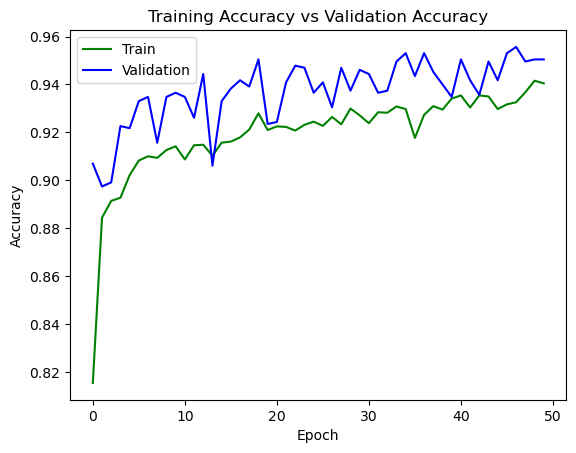

In [16]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Loss:

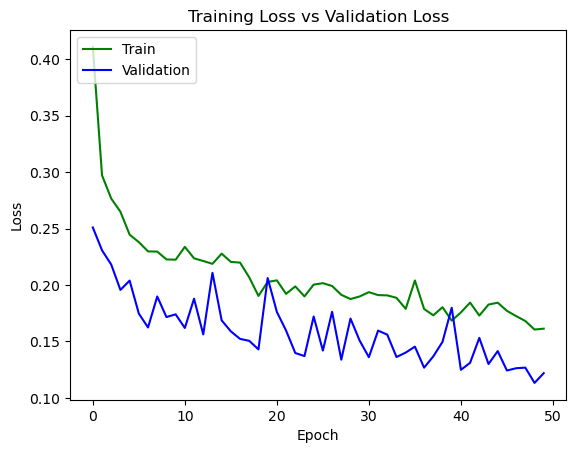

In [17]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing our model

In [18]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']
assign = {'0':'Mask','1':"No Mask"}
gamma = 2.0



detections = {}

# Load Face Detectors
# SSD
ssd = cv2.dnn.readNetFromCaffe('../input/caffe-face-detector-opencv-pretrained-model/architecture.txt','../input/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

# MTCNN
mtcnn = MTCNN()



for j,im in enumerate(test_images):
    img =  cv2.imread(os.path.join(images,im),1)
    img =  adjust_gamma(img, gamma=gamma)
    (h, w) = img.shape[:2]
    
    
    
    # SSD Face Detection
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    ssd.setInput(blob)
    ssd_detections = ssd.forward()
    
    
    # MTCNN Face Detection
    mtcnn_detections = mtcnn.detect_faces(img)
    
    detections[im] = {
        "ssd": ssd_detections,
        "mtcnn": mtcnn_detections
    }
    



        
        
    

1/1 [==============================] - 0s 60ms/step


In [19]:
detections

{'1114.png': {'ssd': array([[[[0.        , 1.        , 0.97635204, ..., 0.08276187,
            0.859738  , 0.35734588],
           [0.        , 1.        , 0.12467492, ..., 4.0027514 ,
            4.840998  , 4.9815865 ],
           [0.        , 1.        , 0.12453763, ..., 0.12452844,
            0.98996955, 0.874491  ],
           ...,
           [0.        , 0.        , 0.        , ..., 0.        ,
            0.        , 0.        ],
           [0.        , 0.        , 0.        , ..., 0.        ,
            0.        , 0.        ],
           [0.        , 0.        , 0.        , ..., 0.        ,
            0.        , 0.        ]]]], dtype=float32),
  'mtcnn': []},
 '1504.jpg': {'ssd': array([[[[0.        , 1.        , 0.9179694 , ..., 0.17618868,
            0.81124645, 0.41033062],
           [0.        , 1.        , 0.59964156, ..., 0.22015813,
            0.37260744, 0.43817756],
           [0.        , 1.        , 0.57443005, ..., 0.11206734,
            0.4285154 , 0.2813

In [20]:
boxes = {}


for im in detections:
    image =  cv2.imread(os.path.join(images,im),1)
    (h, w) = image.shape[:2]
    #print(detections[im]["ssd"])
    boxes[im] = {'ssd':[], 'mtcnn': []}
    
    #print(detections[im]["ssd"].shape[2])
    for i in range(0, detections[im]["ssd"].shape[2]):
        ssd_box = detections[im]["ssd"][0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = ssd_box.astype("int")
        
        ssd_confidence = detections[im]["ssd"][0, 0, i, 2]
        if(ssd_confidence > 0.2):
            boxes[im]['ssd'].append({'box': [startX, startY, endX, endY], 'confidence': ssd_confidence})
       
        
    for detection in detections[im]["mtcnn"]:
        startX, startY, width, height = detection['box']
        endX = startX + width
        endY = startY + height
        
        mtcnn_confidence = detection['confidence']
        boxes[im]['mtcnn'].append({'box': [startX, startY, endX, endY], 'confidence': mtcnn_confidence})

boxes

{'1114.png': {'ssd': [{'box': [425, 52, 545, 226], 'confidence': 0.97635204}],
  'mtcnn': []},
 '1504.jpg': {'ssd': [{'box': [844, 161, 1038, 376], 'confidence': 0.9179694},
   {'box': [329, 202, 476, 402], 'confidence': 0.59964156},
   {'box': [438, 102, 548, 258], 'confidence': 0.57443005}],
  'mtcnn': [{'box': [452, 127, 543, 239], 'confidence': 0.9931653141975403},
   {'box': [859, 167, 1039, 383], 'confidence': 0.9701593518257141}]},
 '0072.jpg': {'ssd': [{'box': [405, 357, 528, 535], 'confidence': 0.98716843},
   {'box': [783, 255, 923, 452], 'confidence': 0.9851549},
   {'box': [214, 285, 339, 460], 'confidence': 0.97986346},
   {'box': [556, 169, 680, 339], 'confidence': 0.9777002}],
  'mtcnn': [{'box': [520, 109, 564, 165], 'confidence': 0.9685935378074646},
   {'box': [557, 178, 674, 331], 'confidence': 0.8928492665290833},
   {'box': [405, 365, 522, 516], 'confidence': 0.8528996109962463},
   {'box': [212, 282, 340, 452], 'confidence': 0.8241784572601318}]},
 '0012.jpg': {'s

In [21]:
final_list = {}
for image in boxes:
    final_list[image] = []
    
    for box in boxes[image]['mtcnn']:
        has_overlap = False
        
        for ssd_box in boxes[image]['ssd']:
            overlap = bop.box_iou(torch.tensor([box['box']]), torch.tensor([ssd_box['box']]))
            if(np.array(overlap)[0][0] > 0):
                has_overlap = True
        
        if not has_overlap:
            final_list[image].append({"box": box['box'], "confidence": box['confidence'], "model": "mtcnn"})
    
    for box in boxes[image]['ssd']:
       final_list[image].append({"box": box['box'], "confidence": box['confidence'], "model": "ssd"}) 
            
final_list

{'1114.png': [{'box': [425, 52, 545, 226],
   'confidence': 0.97635204,
   'model': 'ssd'}],
 '1504.jpg': [{'box': [844, 161, 1038, 376],
   'confidence': 0.9179694,
   'model': 'ssd'},
  {'box': [329, 202, 476, 402], 'confidence': 0.59964156, 'model': 'ssd'},
  {'box': [438, 102, 548, 258], 'confidence': 0.57443005, 'model': 'ssd'}],
 '0072.jpg': [{'box': [520, 109, 564, 165],
   'confidence': 0.9685935378074646,
   'model': 'mtcnn'},
  {'box': [405, 357, 528, 535], 'confidence': 0.98716843, 'model': 'ssd'},
  {'box': [783, 255, 923, 452], 'confidence': 0.9851549, 'model': 'ssd'},
  {'box': [214, 285, 339, 460], 'confidence': 0.97986346, 'model': 'ssd'},
  {'box': [556, 169, 680, 339], 'confidence': 0.9777002, 'model': 'ssd'}],
 '0012.jpg': [{'box': [894, 392, 954, 463],
   'confidence': 0.9991952776908875,
   'model': 'mtcnn'},
  {'box': [1086, 433, 1148, 515],
   'confidence': 0.9975171089172363,
   'model': 'mtcnn'},
  {'box': [83, 375, 131, 432],
   'confidence': 0.739927232265472

1114.png
1/1 [==============================] - 0s 250ms/step
425 52 545 226
(0, 0, 255)
1504.jpg
1/1 [==============================] - 0s 21ms/step
844 161 1038 376
(0, 0, 255)
1/1 [==============================] - 0s 21ms/step
329 202 476 402
(0, 0, 255)
1/1 [==============================] - 0s 20ms/step
438 102 548 258
(0, 0, 255)
0072.jpg
1/1 [==============================] - 0s 23ms/step
520 109 564 165
(0, 255, 0)
1/1 [==============================] - 0s 23ms/step
405 357 528 535
(0, 0, 255)
1/1 [==============================] - 0s 21ms/step
783 255 923 452
(0, 0, 255)
1/1 [==============================] - 0s 20ms/step
214 285 339 460
(0, 0, 255)
1/1 [==============================] - 0s 23ms/step
556 169 680 339
(0, 0, 255)
0012.jpg
1/1 [==============================] - 0s 21ms/step
894 392 954 463
(0, 255, 0)
1/1 [==============================] - 0s 22ms/step
1086 433 1148 515
(0, 255, 0)
1/1 [==============================] - 0s 21ms/step
83 375 131 432
(0, 255, 0)
03

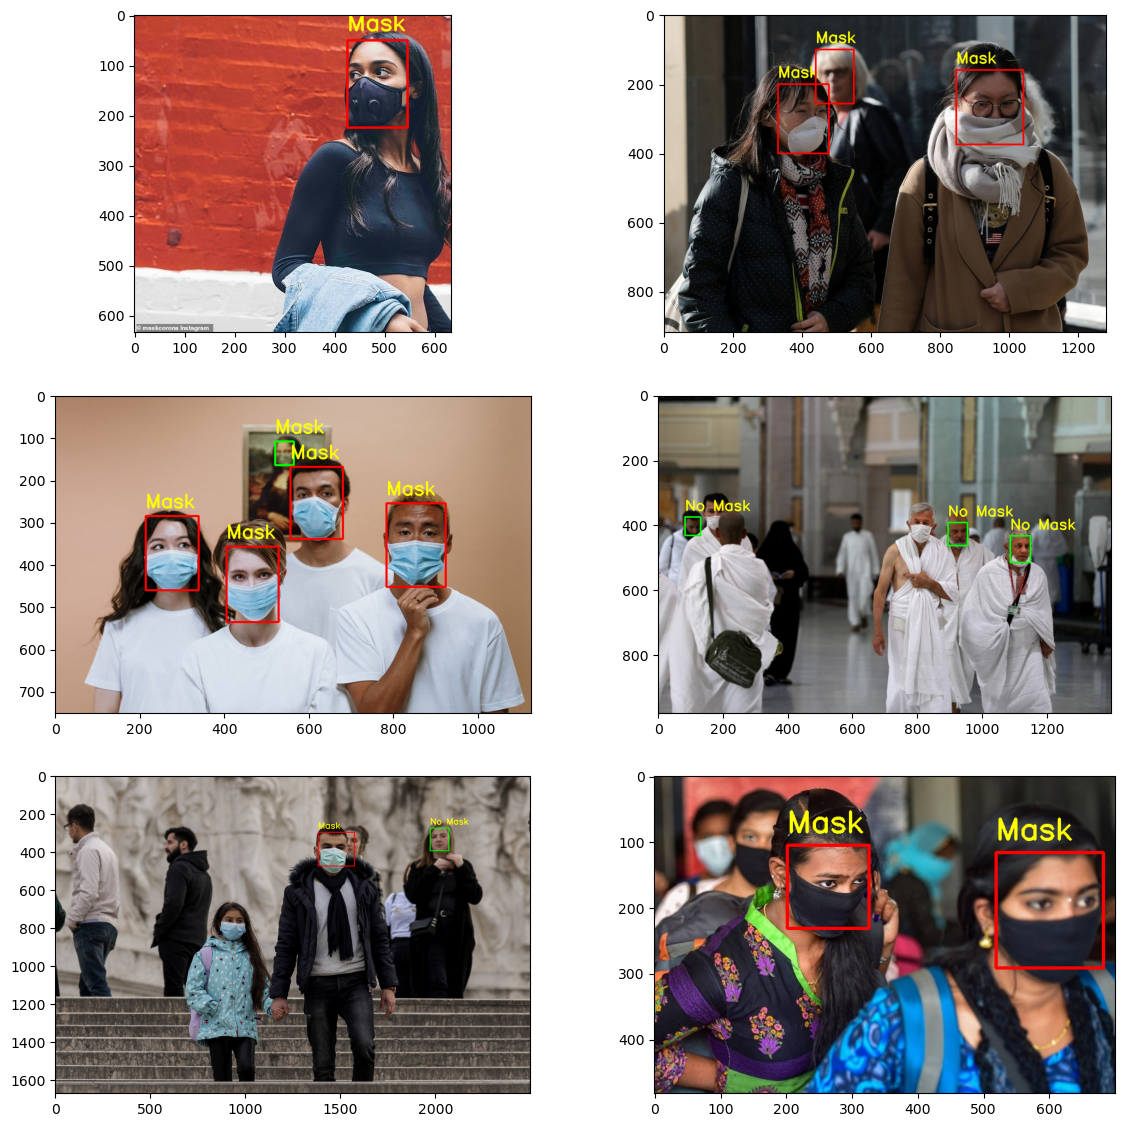

In [22]:
# Test results plot
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
index = 0

for item in final_list:
    print(item)
    index += 1
    
    img =  cv2.imread(os.path.join(images,item),1)
    
    for i in range(0,len(final_list[item])):

        box = final_list[item][i]
        if(box['confidence'] > 0.5):
            x = box['box'][0]
            y = box['box'][1]
            x1 = box['box'][2]
            y1 = box['box'][3]

            frame = img[y:y1, x:x1]
            face = cv2.resize(frame,(img_size,img_size))
            face = np.array(face)/255.0
            face = face.reshape(1,124,124,3)

            result = model.predict(face)
            if result>0.5:
                label_Y = 1
            else:
                label_Y = 0
                
                
            color = None
            
            if box['model'] == "mtcnn":
                color = (0, 255, 0) 
            else:
                color = (0, 0, 255)
                
            print(x, y, x1, y1)
            cv2.rectangle(img, (x, y), (x1, y1), color, 3)
            print(color)
            cv2.putText(img,f'{assign[str(label_Y)]}' , (x, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3)
            
            
    axes.append(fig.add_subplot(rows, cols, index))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
plt.show()